In [ ]:
! pip install transformers
! pip install datasets
! pip install seqeval

In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

In [ ]:
##### Train ###
with open("text_train.txt", 'r', encoding = "utf8") as f:
  lines = f.readlines()
tokens_train = [tokens.replace("\n", "").rstrip().split() for tokens in lines]

with open("labels_train.txt", 'r', encoding = "utf8") as f:
  lines = f.readlines()
ner_tags_train = [ner_tags.replace("\n", "").rstrip().split() for ner_tags in lines]

import pandas as pd
train = pd.DataFrame({'tokens': tokens_train, 'ner_tags': ner_tags_train})

##### Validation ###
with open("text_dev.txt", 'r', encoding = "utf8") as f:
  lines = f.readlines()
tokens_train = [tokens.replace("\n", "").rstrip().split() for tokens in lines]

with open("labels_dev.txt", 'r', encoding = "utf8") as f:
  lines = f.readlines()
ner_tags_train = [ner_tags.replace("\n", "").rstrip().split() for ner_tags in lines]

import pandas as pd
validation = pd.DataFrame({'tokens': tokens_train, 'ner_tags': ner_tags_train})

##### Test ###
with open("text_test.txt", 'r', encoding = "utf8") as f:
  lines = f.readlines()
tokens_train = [tokens.replace("\n", "").rstrip().split() for tokens in lines]

with open("labels_test.txt", 'r', encoding = "utf8") as f:
  lines = f.readlines()
ner_tags_train = [ner_tags.replace("\n", "").rstrip().split() for ner_tags in lines]

import pandas as pd
test = pd.DataFrame({'tokens': tokens_train, 'ner_tags': ner_tags_train})

In [ ]:
print(tokens_train[1])
print(ner_tags_train[1])

['Ataxia', '-', 'telangiectasia', '(', 'A', '-', 'T', ')', 'is', 'a', 'recessive', 'multi', '-', 'system', 'disorder', 'caused', 'by', 'mutations', 'in', 'the', 'ATM', 'gene', 'at', '11q22', '-', 'q23', '(', 'ref', '.', '3', ')', '.']
['B-Disease', 'I-Disease', 'I-Disease', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'I-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
from google.colab import files

train.to_csv('output.csv', encoding = 'utf-8-sig') 
#files.download('output.csv')

In [ ]:
med_df = datasets.DatasetDict({
    "train": Dataset.from_pandas(train),
    "validation": Dataset.from_pandas(validation),
    "test": Dataset.from_pandas(test)
})

med_df

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 5432
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 923
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 940
    })
})

In [ ]:
example = pd.DataFrame(med_df["test"][64])
example

,tokens,ner_tags
0,Germ,O
1,-,O
2,line,O
3,mutations,O
4,of,O
5,the,O
6,BRCA1,O
7,gene,O
8,predispose,O
9,women,O


In [ ]:
med_df

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 5432
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 923
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 940
    })
})

As a quick check that we don’t have any unusual imbalance in the tags, let’s calculate the frequencies of each entity across each split:

In [ ]:
from collections import Counter
from collections import defaultdict
from datasets import DatasetDict

split2freqs = defaultdict(Counter)
split2freqs

for split, dataset in med_df.items():
  for row in dataset["ner_tags"]:
    for tag in row:
      if tag.startswith("B"):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1

pd.DataFrame(split2freqs)

,train,validation,test
Disease,5145,787,960


Seems we only have 1 label: `Disease`. What are the other NER tags in `IOB` format?:

In [ ]:
split2freqs = defaultdict(Counter)
split2freqs

for split, dataset in med_df.items():
  for row in dataset["ner_tags"]:
    for tag in row:
        tag_type = tag
        split2freqs[split][tag_type] += 1

pd.DataFrame(split2freqs)

,train,validation,test
O,124819,22092,22450
B-Disease,5145,787,960
I-Disease,6122,1090,1087


In [ ]:
tag_names = pd.DataFrame(split2freqs).reset_index()["index"].tolist()
tag_names

['O', 'B-Disease', 'I-Disease']

We’ll need to provide some additional information beyond the model name, including the tags that we will use to label each entity and the mapping of each tag to an ID and vice versa. All of this information can be derived as follows:

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(tag_names)}
index2tag
tag2index = {tag: idx for idx, tag in enumerate(tag_names)}
tag2index

{'B-Disease': 1, 'I-Disease': 2, 'O': 0}

In [ ]:
index2tag

{0: 'O', 1: 'B-Disease', 2: 'I-Disease'}

### BioBert

In [ ]:
from transformers import AutoConfig

model_ckpt = "dmis-lab/biobert-v1.1"
AutoConfig.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

BertConfig {
  "_name_or_path": "dmis-lab/biobert-v1.1",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
bio_bert_config = AutoConfig.from_pretrained(model_ckpt, num_labels = len(tag_names),
                                             id2label = index2tag, label2id = tag2index)



In [ ]:
bio_bert_config

BertConfig {
  "_name_or_path": "dmis-lab/biobert-v1.1",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-Disease",
    "2": "I-Disease"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-Disease": 1,
    "I-Disease": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [ ]:
from transformers.models.roberta.modeling_roberta import RobertaModel

In [ ]:
from transformers.models.bert.modeling_bert import BertModel

In [ ]:
import torch.nn as nn
from transformers import BertConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.bert.modeling_bert import BertModel
from transformers.models.bert.modeling_bert import BertPreTrainedModel


In [ ]:
BertModel

transformers.models.bert.modeling_bert.BertModel

In [ ]:
class BioBertForTokenClassification(BertPreTrainedModel):
    config_class = BertConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.bert= BertModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)
        

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BioBertForTokenClassification.from_pretrained(model_ckpt, config = bio_bert_config).to(device)
model

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='dmis-lab/biobert-v1.1', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
text = "Jack Sparrow has cancer!"
bbtokens = tokenizer(text)
bbtokens

{'input_ids': [101, 2132, 23665, 8674, 1144, 4182, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
bbtokens.tokens()

['[CLS]', 'Jack', 'Spa', '##rrow', 'has', 'cancer', '!', '[SEP]']

In [ ]:
input_ids = tokenizer.encode(text, return_tensors = "pt")
input_ids

tensor([[  101,  2132, 23665,  8674,  1144,  4182,   106,   102]])

In [ ]:
pd.DataFrame([bbtokens.tokens(), input_ids[0].numpy()], index = ["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7
Tokens,[CLS],Jack,Spa,##rrow,has,cancer,!,[SEP]
Input IDs,101,2132,23665,8674,1144,4182,106,102


In [ ]:
[bbtokens.tokens(), input_ids[0].numpy()]

[['[CLS]', 'Jack', 'Spa', '##rrow', 'has', 'cancer', '!', '[SEP]'],
 array([  101,  2132, 23665,  8674,  1144,  4182,   106,   102])]

In [ ]:
outputs = model(input_ids.to(device)).logits
outputs.shape #[batch_size, num_tokens, num_tags]

torch.Size([1, 8, 3])

In [ ]:
# Extract the argmax
predictions = torch.argmax(outputs, -1)
predictions[0].cpu().numpy()

array([0, 2, 2, 2, 2, 2, 2, 0])

In [ ]:
preds = [index2tag[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([bbtokens.tokens(), preds], index = ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7
Tokens,[CLS],Jack,Spa,##rrow,has,cancer,!,[SEP]
Tags,O,I-Disease,I-Disease,I-Disease,I-Disease,I-Disease,I-Disease,O


Unsurprisingly, our token classification layer with random weights leaves a lot to be desired; let’s fine-tune on some labeled data to make it better! Before doing so, let’s wrap the preceding steps into a helper function for later use:

In [ ]:
bb_tokenizer = tokenizer
def tag_text(text, tags, model, tokenizer):
  # Get tokens with special characters
  tokens = tokenizer(text).tokens()
  # Encode the sequence into IDs
  input_ids = bb_tokenizer(text, return_tensors = "pt").input_ids.to(device)
  # Get predictions as distribution over 7 possible classes
  outputs = model(input_ids).logits
  # Take argmax to get the most like
  predictions = torch.argmax(outputs, dim = 2)

  # Convert to dataframe
  preds = [index2tag[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])

In [ ]:
tag_text(text, index2tag, model, tokenizer)

,0,1,2,3,4,5,6,7
Tokens,[CLS],Jack,Spa,##rrow,has,cancer,!,[SEP]
Tags,I-Disease,O,I-Disease,O,I-Disease,O,O,I-Disease


Before we can train the model, we also need to tokenize the inputs and prepare the labels. We’ll do that next.

In [ ]:
med_df0 = med_df

In [ ]:
# Add ner tags ids
def create_tag_names(batch):
  return {"ner_tags_idx": [tag2index[ner_tag] for ner_tag in batch["ner_tags"]]}

# Apply function to multiple batches
med_df = med_df.map(create_tag_names)
med_df

Parameter 'function'=<function create_tag_names at 0x7fc1300c1a70> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/5432 [00:00<?, ?ex/s]

  0%|          | 0/923 [00:00<?, ?ex/s]

  0%|          | 0/940 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_idx'],
        num_rows: 5432
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_idx'],
        num_rows: 923
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_idx'],
        num_rows: 940
    })
})

In [ ]:
example = med_df["train"][0]
pd.DataFrame(example)

,tokens,ner_tags,ner_tags_idx
0,Identification,O,0
1,of,O,0
2,APC2,O,0
3,",",O,0
4,a,O,0
5,homologue,O,0
6,of,O,0
7,the,O,0
8,adenomatous,B-Disease,1
9,polyposis,I-Disease,2


In [ ]:
words, labels = example["tokens"], example["ner_tags_idx"]
labels

[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]

In [ ]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words = True)
tokenized_input

{'input_ids': [101, 146, 11951, 5783, 1104, 10997, 1658, 1477, 117, 170, 16358, 3702, 12733, 1104, 1103, 8050, 26601, 21943, 2285, 185, 23415, 5674, 4863, 1884, 2646, 189, 27226, 17203, 1766, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
pd.DataFrame([tokenized_input.tokens()], index = ["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Tokens,[CLS],I,##dent,##ification,of,AP,##C,##2,",",a,...,##po,##sis,co,##li,t,##umour,suppress,##or,.,[SEP]


In this example we can see that the tokenizer has split “Identification” into 3 sub‐ words, “I” , "##dent"and “##ification”. Since we’re following the convention that only “I” should be associated with the B-Disease label, we need a way to mask the subword representations after the first subword. Fortunately, tokenized_input is a class that contains a word_ids() function that can help us achieve this:

In [ ]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokenized_input.tokens(), word_ids], index = ["Tokens", "Word_ids"])

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Tokens,[CLS],I,##dent,##ification,of,AP,##C,##2,",",a,...,##po,##sis,co,##li,t,##umour,suppress,##or,.,[SEP]
Word_ids,None,0,0,0,1,2,2,2,3,4,...,9,9,10,10,11,11,12,12,13,None


Here we can see that word_ids has mapped each subword to the corresponding index in the words sequence. We can also see that special tokens like and are mapped to None. Let’s set –100 as the label for these special tokens and the subwords we wish to mask during training:

In [ ]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  else:
    label_ids.append(example["ner_tags_idx"][word_idx])
  previous_word_idx = word_idx

In [ ]:
example

{'ner_tags': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Disease',
  'I-Disease',
  'I-Disease',
  'I-Disease',
  'O',
  'O'],
 'ner_tags_idx': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0],
 'tokens': ['Identification',
  'of',
  'APC2',
  ',',
  'a',
  'homologue',
  'of',
  'the',
  'adenomatous',
  'polyposis',
  'coli',
  'tumour',
  'suppressor',
  '.']}

In [ ]:
print(label_ids)

[-100, 0, -100, -100, 0, 0, -100, -100, 0, 0, 0, -100, -100, 0, 0, 1, -100, -100, -100, 2, -100, -100, -100, 2, -100, 2, -100, 0, -100, 0, -100]


In [ ]:
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

In [ ]:
pd.DataFrame([tokenized_input.tokens(), word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Tokens,[CLS],I,##dent,##ification,of,AP,##C,##2,",",a,...,##po,##sis,co,##li,t,##umour,suppress,##or,.,[SEP]
Word IDs,None,0,0,0,1,2,2,2,3,4,...,9,9,10,10,11,11,12,12,13,None
Label IDs,-100,0,-100,-100,0,0,-100,-100,0,0,...,-100,-100,2,-100,2,-100,0,-100,0,-100
Labels,IGN,O,IGN,IGN,O,O,IGN,IGN,O,O,...,IGN,IGN,I-Disease,IGN,I-Disease,IGN,O,IGN,O,IGN


And that’s it! We can clearly see how the label IDs align with the tokens, so let’s scale this out to the whole dataset by defining a single function that wraps all the logic:

In [ ]:
med_df["train"]["ner_tags"]

In [ ]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"], truncation = True, is_split_into_words=True)
  labels = []

  for idx, label in enumerate(examples["ner_tags_idx"]):
    word_ids = tokenized_inputs.word_ids(batch_index = idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)

  tokenized_inputs["labels"] = labels
  return tokenized_inputs






In [ ]:
def encode_med_df(corpus):
  return corpus.map(tokenize_and_align_labels, batched = True, remove_columns = ['ner_tags_idx', "tokens", "ner_tags"])

med_df_decoded = encode_med_df(med_df)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
med_df_decoded["train"][0]

### Performance metrics

Evaluating a NER model is similar to evaluating a text classification model, and it is common to report results for precision, recall, and F1 -score. The only subtlety is that all words of an entity need to be predicted correctly in order for a prediction to be counted as correct. Fortunately, there is a nifty library called seqeval that is designed for these kinds of tasks. For example, given some placeholder NER tags and model predictions, we can compute the metrics via seqeval’s classification_report() function:

In [ ]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC"], ["O", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         2
   macro avg       0.00      0.00      0.00         2
weighted avg       0.00      0.00      0.00         2



As we can see, seqeval expects the predictions and labels as lists of lists, with each list corresponding to a single example in our validation or test sets. we need a function that can take the outputs of the model and convert them into the lists that seqeval expects. The following does the trick by ensuring we ignore the label IDs associated with subsequent subwords:

In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis = 2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)


  return preds_list, labels_list

      


### Fine tune bio-bert

Equipped with a performance metric, we can move on to actually training the model



In [ ]:
from transformers import TrainingArguments

num_epochs = 10
batch_size = 32
logging_steps = len(med_df_decoded["train"]) // batch_size
model_name = "bio_bert_ft"
training_args = TrainingArguments(
    output_dir = model_name,
    log_level = "error",
    num_train_epochs = num_epochs,
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size = batch_size,
    evaluation_strategy = "epoch",
    # Set to a large number to disable checkpointing and speed up training
    save_steps = 1e6,
    weight_decay = 0.01,
    disable_tqdm = False,
    logging_steps = logging_steps,
    push_to_hub = True


)


ModuleNotFoundError: ignored

Here we evaluate the model’s predictions on the validation set at the end of every epoch, tweak the weight decay, and set save_steps to a large number to disable checkpointing and thus speed up training.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


We also need to tell the Trainer how to compute metrics on the validation set, so here we can use the align_predictions() function that we defined earlier to extract the predictions and labels in the format needed by seqeval to calculate the F1 -score:

In [ ]:
from seqeval.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1" : f1_score(y_true, y_pred), "accuracy": accuracy_score(y_true, y_pred)}

The final step is to define a data collator so we can pad each input sequence to the largest sequence length in a batch. Transformers provides a dedicated data collator for token classification that will pad the labels along with the inputs

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=PreTrainedTokenizerFast(name_or_path='dmis-lab/biobert-v1.1', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

Padding the labels is necessary because, unlike in a text classification task, the labels are also sequences. One important detail here is that the label sequences are padded with the value –100, which, as we’ve seen, is ignored by PyTorch loss functions. We will train several models in the course of this chapter, so we’ll avoid initializing a new model for every Trainer by creating a model_init() method. This method loads an untrained model and is called at the beginning of the train() call:

In [ ]:
model_ckpt = "dmis-lab/biobert-v1.1"
def model_init():
  return BioBertForTokenClassification.from_pretrained(model_ckpt, config = bio_bert_config).to(device)

We can now pass all this information together with the encoded datasets to the Trainer:

In [ ]:
from transformers import Trainer

trainer = Trainer(model_init = model_init,
                  args = training_args,
                  data_collator = data_collator,
                  compute_metrics = compute_metrics,
                  train_dataset = med_df_decoded["train"],
                  eval_dataset = med_df_decoded["validation"],
                  tokenizer = tokenizer)


ValueError: ignored

In [ ]:
## train model
trainer.train() 

In [ ]:
#trainer.push_to_hub(commit_message= "Done!")

In [ ]:
# Metrics for validation set
metrics = trainer.evaluate()
metrics

In [ ]:
# Same thing
trainer.evaluate(med_df_decoded["validation"])

In [ ]:
# Get raw probabilities
pred_valid = trainer.predict(med_df_decoded["validation"])
pred_valid.metrics

These F1 scores are quite good for a NER model. To confirm that our model works as
expected, let’s test it on a simple example:

In [ ]:
text = "Jack sparrow got Malaria and diarrhoea in New York"
tag_text(text, index2tag, model, tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,[CLS],Jack,spa,##rrow,got,Mal,##aria,and,di,##ar,##r,##hoe,##a,in,New,York,[SEP]
Tags,O,O,O,O,O,B-Disease,I-Disease,O,B-Disease,I-Disease,I-Disease,I-Disease,I-Disease,O,O,O,O


It works! But we should never get too confident about performance based on a single
example. Instead, we should conduct a proper and thorough investigation of the
model’s errors. In the next section we explore how to do this for the NER task.

### Error Analysis

a thorough error analysis
of your model is one of the most important aspects when training and debugging
transformers (and machine learning models in general). There are several failure
modes where it might look like the model is performing well, while in practice it has
some serious flaws. 

For our analysis we will again use one of the most powerful tools at our disposal,
which is to look at the `validation examples with the highest loss`. We can reuse much
of the function we built to analyze the sequence classification model in Chapter 2, but
we’ll now calculate a loss per token in the sample sequence.
Let’s define a method that we can apply to the validation set:

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained("ericntay/bio_bert_ft")
tokenizer = AutoTokenizer.from_pretrained("ericntay/bio_bert_ft")

In [ ]:
med_df_decoded["validation"][0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
  26660,
  11356,
  1475,
  1110,
  3318,
  1174,
  1105,
  10877,
  4625,
  1104,
  170,
  176,
  23851,
  1179,
  119,
  102],
 'labels': [-100,
  0,
  -100,
  -100,
  0,
  0,
  -100,
  0,
  0,
  0,
  0,
  0,
  0,
  -100,
  -100,
  0,
  -100],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
def forward_pass_with_label(batch):
  # convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]

  # Pad inputs and labels and put all tensors on device
  batch = data_collator(features)

batch2 = med_df_decoded["validation"]

batch2 = batch2.map(forward_pass_with_label, batched =True, batch_size = 32)

  0%|          | 0/29 [00:00<?, ?ba/s]

In [ ]:
batch2

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 923
})

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]

  # Pad inputs and labels and put all tensors on device
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  token_type_ids = batch["token_type_ids"].to(device)
  labels = batch["labels"].to(device)

  # Disable gradient calculation for inference
  with torch.no_grad():
    # Pass data through model
    output = model(input_ids, token_type_ids, attention_mask)
    # logit.shape: [batch_size, sequence_length, attention_mask]
    # Predicted class with largest logit value
    predicted_label = torch.argmax(output.logits, axis = -1).cpu().numpy()
  
  # Calculate loss per token after flattening batch dimentions
  # -1 is a PyTorch alias for "infer this dimension given the others have all been specified"
  loss = cross_entropy(output.logits.view(-1, 3),
                       labels.view(-1), reduction = "none")
  
  # Unflatten batch dimensions and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()
  
  return {"loss": loss, "predicted_label": predicted_label}

  




We can now apply this function to the whole validation set using map() and load all
the data into a DataFrame for further analysis:


In [ ]:
## Dont run this again:(
valid_set = med_df_decoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched = True, batch_size = 32)


  0%|          | 0/29 [00:00<?, ?ba/s]

In [ ]:
df = valid_set.to_pandas()

In [ ]:
df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label
0,"[101, 26660, 11356, 1475, 1110, 3318, 1174, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, 0, 0, -100, 0, 0, 0, 0, ...","[0.0, 7.724464e-05, 0.0, 0.0, 1.442422e-05, 1....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


The tokens and the labels are still encoded with their IDs, so let’s map the tokens and
labels back to strings to make it easier to read the results. For the padding tokens with
label –100 we assign a special label, IGN, so we can filter them later. We also get rid of
all the padding in the loss and predicted_label fields by truncating them to the
length of the inputs:

In [ ]:
index2tag[-100] = "IGN"

df["input_tokens"] = df["input_ids"].apply(lambda x: tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x: x['loss'][:len(x["input_ids"])], axis = 1)
df["predicted_label"] = df.apply(lambda x: x["predicted_label"][:len(x["input_ids"])], axis = 1)

In [ ]:
df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 26660, 11356, 1475, 1110, 3318, 1174, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, O, O, IGN, O, O, O, O, O, O...","[0.0, 7.724464e-05, 0.0, 0.0, 1.442422e-05, 1....","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], BR, ##CA, ##1, is, secret, ##ed, and, ..."


Each column contains a list of tokens, labels, predicted labels, and so on for each
sample. Let’s have a look at the tokens individually by unpacking these lists. The
pandas.Series.explode() function allows us to do exactly that in one line by creat‐
ing a row for each element in the original rows list. Since all the lists in one row have
the same length, we can do this in parallel for all columns. We also drop the padding
tokens we named IGN, since their loss is zero anyway. Finally, we cast the losses, which
are still numpy.Array objects, to standard floats:

In [ ]:
# Similar to pivot longer?
df_tokens = df.apply(pd.Series.explode)
# Drop all padding features since loss is zero
df_tokens = df_tokens.query("labels != 'IGN'")
# Cast losses as float since they are array objects
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)

In [ ]:
df_tokens.head(20)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,26660,0,1,O,0.0,O,BR
0,1110,0,1,O,0.0,O,is
0,3318,0,1,O,0.0,O,secret
0,1105,0,1,O,0.0,O,and
0,10877,0,1,O,0.0,O,exhibits
0,4625,0,1,O,0.0,O,properties
0,1104,0,1,O,0.0,O,of
0,170,0,1,O,0.0,O,a
0,176,0,1,O,0.0,O,g
0,119,0,1,O,0.0,O,.


With the data in this shape, we can now group it by the input tokens and aggregate
the losses for each token with the count, mean, and sum. Finally, we sort the
aggregated data by the sum of the losses and see which tokens have accumulated the
most loss in the validation set:


In [ ]:
df_tokens.groupby("input_tokens")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level = 0, axis = 1).sort_values(by = "sum", ascending = False).reset_index().round(2).head(10).T

,0,1,2,3,4,5,6,7,8,9
input_tokens,-,cancer,V,breast,and,A,C,s,deficiency,def
count,643,147,62,102,558,92,118,48,39,24
mean,0.5,0.74,1.75,1.05,0.18,1.05,0.66,1.46,1.67,2.68
sum,319.8,109.05,108.72,106.9,101.18,96.49,77.6,69.93,65.21,64.31


We can observe several patterns in this list:

- `-` and `cancer` have the highest total loss which is not surprising as they might be very common in the list. However the mean loss is much lower than others meaning the model doesn't struggle to classify them.

We can also group the label IDs and look at the losses for each class:


In [ ]:
df_tokens.groupby("labels")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level = 0, axis = 1).sort_values(by = "mean", ascending = False).reset_index().round(2).T

,0,1,2
labels,B-Disease,I-Disease,O
count,787,1090,22092
mean,2.2,1.89,0.01
sum,1734.11,2055.57,326.69


We can see that B-Disease has the highest average loss which means determining the beginning of a disease poses a challenge to our model. We can break this down further by plotting the confusion matrix where we see that the beginning of a disease is often confused with the subsequent I-Disease token

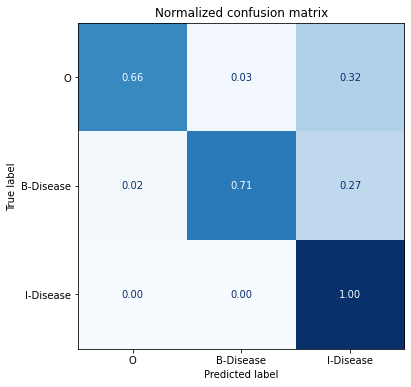

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["predicted_label"], df_tokens["labels"], tag_names)

Now that we've examined errors at the token level, let's move on and look at sequences with high losses by summing over the loss per token. To do this, let's first write a function that helps us display the token sequences with the labels and losses:

In [ ]:
def get_samples(df):
  #Iterate over DataFrame rows as (index, Series) pairs.
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp
    

In [ ]:
df["total_losss"] = df["loss"].apply(lambda x: sum(x))

In [ ]:
df_tmp = df.sort_values(by = "total_losss", ascending = False).head(3)
df_tmp

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens,total_losss
103,"[101, 2189, 14601, 3322, 1276, 1107, 26660, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, B-Disease, O, O, O, O, IGN, IGN, O, O...","[0.0, 4.494089e-05, 5.6593823, 4.6371337e-05, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], Other, tumor, types, found, in, BR, ##...",99.324961
748,"[101, 1109, 17834, 118, 13263, 10522, 9318, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, B-Disease, I-Disease, I-Disease, IGN,...","[0.0, 4.8517002e-05, 9.712391, 8.973303, 7.972...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], The, Schwartz, -, Jam, ##pel, syndrome...",98.571958
763,"[101, 160, 1942, 1475, 17157, 1138, 1145, 1151...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, O, O, O, O, O, O, B-Disease...","[0.0, 3.6596583e-05, 0.0, 0.0, 3.2305197e-05, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], W, ##T, ##1, mutations, have, also, be...",91.629414


In [ ]:
for samples in get_samples(df_tmp):
  display(samples)

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
tokens,Other,tumor,types,found,in,BR,##CA,##1,mutation,/,...,",",and,a,car,##cin,##osa,##rc,##oma,.,[SEP]
labels,O,B-Disease,O,O,O,O,IGN,IGN,O,O,...,O,O,O,B-Disease,IGN,IGN,IGN,IGN,O,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
losses,0.00,5.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.62,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
tokens,The,Schwartz,-,Jam,##pel,syndrome,(,S,##J,##S,...,stature,",",and,bone,d,##ys,##p,##lasia,.,[SEP]
labels,O,B-Disease,I-Disease,I-Disease,IGN,I-Disease,O,B-Disease,IGN,IGN,...,I-Disease,O,O,B-Disease,I-Disease,IGN,IGN,IGN,O,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,B-Disease,I-Disease,I-Disease,I-Disease,O,O,O
losses,0.00,9.71,8.97,7.97,0.00,6.46,0.00,7.43,0.00,0.00,...,9.33,0.00,0.00,0.35,0.09,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
tokens,W,##T,##1,mutations,have,also,been,reported,in,juvenile,...,acute,my,##elo,##id,le,##uke,##mia,.,.,[SEP]
labels,O,IGN,IGN,O,O,O,O,O,O,B-Disease,...,B-Disease,I-Disease,IGN,IGN,I-Disease,IGN,IGN,O,O,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,I-Disease,O,O,I-Disease,I-Disease,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.59,...,2.75,0.52,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00


It appears that something is wrong for these samples. For instance `juvenile` was labelled as as disease.

In [ ]:
from transformers import pipeline

ner_classifer = pipeline("ner", model = "ericntay/bio_bert_ft")

In [ ]:
text = "Jack Sparrow from New York has dimentia and Malaria"
ner_classifer(text, aggregation_strategy = "simple")

[{'end': 34,
  'entity_group': 'Disease',
  'score': 0.9855327,
  'start': 31,
  'word': 'dim'},
 {'end': 51,
  'entity_group': 'Disease',
  'score': 0.9891751,
  'start': 44,
  'word': 'Malaria'}]

## Interpreting NER models using Integrated gradients

In [ ]:
! pip install transformers-interpret==0.7.2

In [4]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained("ericntay/bio_bert_ft")
tokenizer = AutoTokenizer.from_pretrained("ericntay/bio_bert_ft")

/home/vscode/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 832/832 [00:00<00:00, 627kB/s]
Downloading: 100%|██████████| 411M/411M [00:11<00:00, 38.4MB/s] 
Downloading: 100%|██████████| 570/570 [00:00<00:00, 405kB/s]
Downloading: 100%|██████████| 208k/208k [00:00<00:00, 650kB/s] 
Downloading: 100%|██████████| 653k/653k [00:00<00:00, 1.64MB/s]
Downloading: 100%|██████████| 125/125 [00:00<00:00, 114kB/s]


Exploring the possible entity tags that this model classifies each token into:

In [10]:
model.config.id2label

{0: 'O', 1: 'B-Disease', 2: 'I-Disease'}

Import the TokenClassificationExplainer from the transformers interpret package.

In [11]:
from transformers_interpret import TokenClassificationExplainer

Create instance of explainer providing model and tokenizer

In [12]:
ner_explainer = TokenClassificationExplainer(model=model, tokenizer=tokenizer)
ner_explainer

## Basic usage

Call the explainer to generate the attributions. In the NER task, for each token of the sentence, the predicted class is considered as the target and the attributions of the rest of the tokens are calculated. The algorithm used is **[Layer Integrated Gradients](https://captum.ai/docs/algorithms)** 

In [13]:
text = "Jack Sparrow from New York has dimentia and Malaria"
attributions = ner_explainer(text)

In [14]:
attributions

{'[CLS]': {'label': 'O',
  'attribution_scores': [('[CLS]', 0.0),
   ('Jack', -0.2070060390344098),
   ('Spa', -0.13154725646209198),
   ('##rrow', 0.1436007361457289),
   ('from', 0.2650080235318202),
   ('New', 0.1963838272831451),
   ('York', 0.07223659511963693),
   ('has', 0.012787204803636997),
   ('dim', 0.6555497123174213),
   ('##ent', -0.17497986682451258),
   ('##ia', 0.3773258402083622),
   ('and', -0.3242835352106864),
   ('Mal', 0.20505743745930674),
   ('##aria', 0.23473094511537426),
   ('[SEP]', 0.0)]},
 'Jack': {'label': 'O',
  'attribution_scores': [('[CLS]', 0.0),
   ('Jack', 0.0028113943473978015),
   ('Spa', -0.19113440365604328),
   ('##rrow', -0.25341476030993443),
   ('from', 0.2101013307828172),
   ('New', 0.08118384710300779),
   ('York', 0.004943305958504588),
   ('has', 0.3147787028436281),
   ('dim', 0.7869690616234288),
   ('##ent', 0.012403014582358023),
   ('##ia', -0.24909685037424903),
   ('and', -0.19597893590717527),
   ('Mal', 0.13378360895364452),

**Visualizing explanations**


In [15]:
html = ner_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
O,O (1.00),[CLS],1.32,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (1.00),Jack,0.55,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (1.00),Spa,-0.09,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (1.00),##rrow,-0.14,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (1.00),from,0.99,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (1.00),New,0.30,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (1.00),York,0.39,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (1.00),has,0.10,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
B-Disease,B-Disease (0.99),dim,0.97,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]
O,O (0.97),##ent,-0.45,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]


Perhaps we don't need all that? Let's say we wanted to explain attributions of dimentia

In [29]:
attributions_2 = ner_explainer(text, ignored_indexes=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14])

In [30]:
html = ner_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
B-Disease,B-Disease (0.99),dim,0.97,[CLS] Jack Spa ##rrow from New York has dim ##ent ##ia and Mal ##aria [SEP]


In the image above we see that "Malaria" contributed most to tagging "dim" as "B-Disease" while the word "dim" itself contributed negatively to its tagging. To understand this further, we can look into the contribution of the word embedding and position embedding for the word "dim" in the next section

In [6]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [8]:
text = "Jack Sparrow from New York has dimentia and Malaria"
word_tensors = tokenizer(text, return_tensors = "pt")
word_tensors

{'input_ids': tensor([[  101,  2132, 23665,  8674,  1121,  1203,  1365,  1144, 12563,  3452,
          1465,  1105, 18880, 11315,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
word_tensors.tokens()

['[CLS]',
 'Jack',
 'Spa',
 '##rrow',
 'from',
 'New',
 'York',
 'has',
 'dim',
 '##ent',
 '##ia',
 'and',
 'Mal',
 '##aria',
 '[SEP]']

In [ ]:
input_ids = word_tensors.input_ids # batch_size, num_words
token_type_ids = word_tensors.token_type_ids
attention_mask = word_tensors.attention_mask
input_ids

tensor([[  101,  2132, 23665,  8674,  1121,  1203,  1365,  1144, 12563,  3452,
          1465,  1105, 18880, 11315,   102]])

In [ ]:
position_ids = torch.tensor([[x for x in range(15)]])

While working with attribution based methods we need a reference sentence. In this case, we can substitute every word in the original sentence with '[PAD]' and use it as reference. The model will first see how the information flows from input to the output from baseline. Then it will determine how the information flow differs for the sentence we are interested in

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
torch.cuda.is_available()

False

In [ ]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [ ]:
word_tensors

{'input_ids': tensor([[  101,  2132, 23665,  8674,  1121,  1203,  1365,  1144, 12563,  3452,
          1465,  1105, 18880, 11315,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)

(tensor([[  101,  2132, 23665,  8674,  1121,  1203,  1365,  1144, 12563,  3452,
           1465,  1105, 18880, 11315,   102]]),
 tensor([[101,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          102]]),
 13)

In [ ]:
construct_input_ref_token_type_pair(input_ids)

(tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [ ]:
construct_input_ref_pos_id_pair(input_ids)

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [ ]:
construct_attention_mask(input_ids)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
indices=input_ids[0].detach().tolist()

In [ ]:
tokenizer.convert_ids_to_tokens(indices)

['[CLS]',
 'Jack',
 'Spa',
 '##rrow',
 'from',
 'New',
 'York',
 'has',
 'dim',
 '##ent',
 '##ia',
 'and',
 'Mal',
 '##aria',
 '[SEP]']

In [ ]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [ ]:
input_ids

tensor([[  101,  2132, 23665,  8674,  1121,  1203,  1365,  1144, 12563,  3452,
          1465,  1105, 18880, 11315,   102]])

In [ ]:
ref_input_ids

tensor([[101,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         102]])

In [ ]:
# Tokens - cls/sep
sep_id

13

In [ ]:
token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
ref_token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
ref_token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
print(position_ids)
print(ref_position_ids)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
token_type_ids = word_tensors.token_type_ids.to(dtype = torch.long)
ref_token_type_ids = token_type_ids

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
model(input_ids, token_type_ids, attention_mask, position_ids = position_ids)[0][0][8].max(0).values.unsqueeze(0)

tensor([5.0124], grad_fn=<UnsqueezeBackward0>)

In [ ]:
A=torch.arange(5, dtype= torch.float) - 3
torch.norm(A)

tensor(3.8730)